<a href="https://colab.research.google.com/github/Gaurav-phatkare/Retrieval-Augmented-Generation_RAG/blob/main/RAG_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!nvidia-smi

Fri Aug  2 14:11:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
import torch

## building

1. Open a PDF document
2. Format the text of that PDF suitable for embedding model
3. embed into chunks and then convert it into numerical representation
4. use vector db to search relevent cuunk
5. crete prompt that incoporates the retrived peices of text
6. generate answer

## Import PDF


In [18]:
import os
import requests

pdf_path = "human-nutrition-text.pdf"

# download PDF

if not os.path.exists(pdf_path):
  print("File doesnt exists")

  url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

  filename = pdf_path
  res = requests.get(url)

  if res.status_code == 200:
    with open(filename, "wb") as file:
      file.write(res.content)
    print(f"file has been downloaded and stored as {filename}")

  else:
    print(f"failed to download file, Status code : {res.status_code}")
else:
  print("file exists")

File doesnt exists
file has been downloaded and stored as human-nutrition-text.pdf


In [19]:
!pip install pyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 28.2 MB/s eta 0:00:00


In [20]:
!pip install tqdm

In [21]:
import fitz
from tqdm.auto import tqdm


def text_formatter(text:str):
  cleaned_text = text.replace("\n", " ").strip()
  return cleaned_text


def open_and_read_pdf(pdf_path):
  doc = fitz.open(pdf_path)

  pages_and_texts = []

  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()

    text = text_formatter(text=text)

    pages_and_texts.append({"page_number" : page_number - 41,
                            "page_char_count" : len(text),
                            "page_word_count" : len(text.split(" ")),
                            "page_sentence_count_raw" : len(text.split(". ")),
                            "page_token_count": len(text) / 4,
                            "text" : text})

  return pages_and_texts


pages_and_texts = open_and_read_pdf(pdf_path)
pages_and_texts[:3]




0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''},
 {'page_number': -39,
  'page_char_count': 320,
  'page_word_count': 54,
  'page_sentence_count_raw': 1,
  'page_token_count': 80.0,
  'text': 'Human Nutrition: 2020  Edition  UNIVERSITY OF HAWAI‘I AT MĀNOA  FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM  ALAN TITCHENAL, SKYLAR HARA,  NOEMI ARCEO CAACBAY, WILLIAM  MEINKE-LAU, YA-YUN YANG, MARIE  KAINOA FIALKOWSKI REVILLA,  JENNIFER DRAPER, GEMADY  LANGFELDER, CHERYL GIBBY, CHYNA  NICOLE CHUN, AND ALLISON  CALABRESE'}]

In [22]:
import random

random.sample(pages_and_texts, 2)

[{'page_number': 351,
  'page_char_count': 1572,
  'page_word_count': 283,
  'page_sentence_count_raw': 12,
  'page_token_count': 393.0,
  'text': 'A Personal Choice about  Lipids  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  A Guide to Making Sense of Dietary Fat  On your next trip to the grocery store prepare yourself to read  all food labels carefully and to seriously consider everything that  goes into your shopping cart. Create a shopping list and divide your  list into columns for “Best,” “Better,” “Good,” “Least Desirable,” and  “Infrequent Foods.” As you refine your sense of dietary fat, here are  key points to bear in mind:  • Shopping for groceries. Don’t be bombarded with gratuitous  grams of saturated fats and empty grams of trans fats. Read  and decipher food labels carefully so that you know exactly  what types of fat a food item contains and how much fat it will  contribute to your overall fat intake. For snacks an

In [23]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...


In [24]:


df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00000,1208.000000,1208.000000,1208.000000,1208.000000
mean,562.50000,1148.594371,198.889901,9.972682,287.148593
std,348.86387,560.441673,95.747365,6.187226,140.110418
min,-41.00000,0.000000,1.000000,1.000000,0.000000
25%,260.75000,762.750000,134.000000,4.000000,190.687500
50%,562.50000,1232.500000,215.000000,10.000000,308.125000
75%,864.25000,1605.250000,271.250000,14.000000,401.312500
max,1166.00000,2308.000000,429.000000,32.000000,577.000000


In [25]:
# Text processing
from spacy.lang.en import English

nlp = English()


nlp.add_pipe('sentencizer')


doc = nlp("this is a sentence. This is another sentence... . I love tensorflow.")

# assert len(list(doc.sents)) == 3

list(doc.sents)

[this is a sentence., This is another sentence... ., I love tensorflow.]

In [26]:
for item in tqdm(pages_and_texts):
  item['sentences'] =  list(nlp(item['text']).sents)

  item['sentences'] = [str(sentence) for sentence in item['sentences']]

  item['page_sentence_count_spacy'] = len(item['sentences'])



  0%|          | 0/1208 [00:00<?, ?it/s]

In [27]:
random.sample(pages_and_texts, 1)

[{'page_number': 1161,
  'page_char_count': 1587,
  'page_word_count': 250,
  'page_sentence_count_raw': 18,
  'page_token_count': 396.75,
  'text': 'Mariana Ruiz / Public Domain  22. Exercise 7.2 reused “Red Cross Doctor” by Clker-Free-Vector- Images\xa0/ Pixabay License  23. Exercise 7.2 reused “Industrial Safety Signal Symbol” by  DavidRockDesign\xa0/ Pixabay License  24. Exercise 9.1 reused “Vitamins as Antioxidants” by Allison  Calabrese  25. Exercise 9.1a reused\xa0“Digestive system without labels” by  Mariana Ruiz / Public Domain  26. Exercise 9.1b reused “Vitamins as Antioxidants” by Allison  Calabrese  27. Exercise 10.2 & 11.3 reused “Milk Carton” by AnnaliseArt\xa0/  Pixabay License  28. Exercise 10.2 reused “Carton Drink Juice” by OpenClipart- Vectors\xa0/ Pixabay License  29. Exercise 10.2 & 11.3 reused “Swiss Cheese” by OpenClipart- Vectors\xa0/ Pixabay License  30. Exercise 10.2 reused “Merchandise Container Plastic” by  BUMIPUTRA\xa0/ Pixabay License  31. Exercise 10.2 &

In [28]:
df = pd.DataFrame(pages_and_texts)

df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000
mean,562.50000,1148.594371,198.889901,9.972682,287.148593,10.319536
std,348.86387,560.441673,95.747365,6.187226,140.110418,6.300843
min,-41.00000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,260.75000,762.750000,134.000000,4.000000,190.687500,5.000000
50%,562.50000,1232.500000,215.000000,10.000000,308.125000,10.000000
75%,864.25000,1605.250000,271.250000,14.000000,401.312500,15.000000
max,1166.00000,2308.000000,429.000000,32.000000,577.000000,28.000000


In [29]:
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,sentences,page_sentence_count_spacy
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition,[Human Nutrition: 2020 Edition],1
1,-40,0,1,1,0.00,,[],0
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...,[Human Nutrition: 2020 Edition UNIVERSITY OF...,1
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...,[Human Nutrition: 2020 Edition by University o...,1
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...,[Contents Preface University of Hawai‘i at M...,2


In [30]:
chunk_size = 10

def split_list(input_list, slice_size = chunk_size):

  return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

test_list = list(range(25))

split_list(test_list)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24]]

In [31]:
for item in tqdm(pages_and_texts):
  item['sentence_chunks'] = split_list(input_list = item['sentences'], slice_size = chunk_size)

  item['num_chunks'] = len(item['sentence_chunks'])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [32]:
random.sample(pages_and_texts, 1)

[{'page_number': 566,
  'page_char_count': 114,
  'page_word_count': 24,
  'page_sentence_count_raw': 1,
  'page_token_count': 28.5,
  'text': 'Image by  Allison  Calabrese /  CC BY 4.0  Figure 9.13 Niacin Deficiency, Pellagra  566  |  Water-Soluble Vitamins',
  'sentences': ['Image by  Allison  Calabrese /  CC BY 4.0  Figure 9.13 Niacin Deficiency, Pellagra  566  |  Water-Soluble Vitamins'],
  'page_sentence_count_spacy': 1,
  'sentence_chunks': [['Image by  Allison  Calabrese /  CC BY 4.0  Figure 9.13 Niacin Deficiency, Pellagra  566  |  Water-Soluble Vitamins']],
  'num_chunks': 1}]

In [33]:
df = pd.DataFrame(pages_and_texts)

df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,1208.00000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000,1208.000000
mean,562.50000,1148.594371,198.889901,9.972682,287.148593,10.319536,1.525662
std,348.86387,560.441673,95.747365,6.187226,140.110418,6.300843,0.644397
min,-41.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,260.75000,762.750000,134.000000,4.000000,190.687500,5.000000,1.000000
50%,562.50000,1232.500000,215.000000,10.000000,308.125000,10.000000,1.000000
75%,864.25000,1605.250000,271.250000,14.000000,401.312500,15.000000,2.000000
max,1166.00000,2308.000000,429.000000,32.000000,577.000000,28.000000,3.000000


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   page_number                1208 non-null   int64  
 1   page_char_count            1208 non-null   int64  
 2   page_word_count            1208 non-null   int64  
 3   page_sentence_count_raw    1208 non-null   int64  
 4   page_token_count           1208 non-null   float64
 5   text                       1208 non-null   object 
 6   sentences                  1208 non-null   object 
 7   page_sentence_count_spacy  1208 non-null   int64  
 8   sentence_chunks            1208 non-null   object 
 9   num_chunks                 1208 non-null   int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 94.5+ KB


In [35]:
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text,sentences,page_sentence_count_spacy,sentence_chunks,num_chunks
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition,[Human Nutrition: 2020 Edition],1,[[Human Nutrition: 2020 Edition]],1
1,-40,0,1,1,0.00,,[],0,[],0
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...,[Human Nutrition: 2020 Edition UNIVERSITY OF...,1,[[Human Nutrition: 2020 Edition UNIVERSITY O...,1
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...,[Human Nutrition: 2020 Edition by University o...,1,[[Human Nutrition: 2020 Edition by University ...,1
4,-37,797,145,2,199.25,Contents Preface University of Hawai‘i at Mā...,[Contents Preface University of Hawai‘i at M...,2,[[Contents Preface University of Hawai‘i at ...,1


In [36]:
# splitting each chunk into its own item

import re

pages_and_chunks = []

for item in tqdm(pages_and_texts):
  for sentence_c in item['sentence_chunks']:
    chunk_dict = {}

    chunk_dict['page_number'] = item['page_number']

    joined_sent_chunk = "".join(sentence_c).replace("  ", " ").strip()
    joined_sent_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sent_chunk)

    chunk_dict['sentence_chunk'] = joined_sent_chunk

    chunk_dict['chunk_char_count'] = len(joined_sent_chunk)

    chunk_dict['chunk_word_count'] = len([word for word in joined_sent_chunk.split(" ")])
    chunk_dict['chunk_token_count'] = len(joined_sent_chunk) / 4

    pages_and_chunks.append(chunk_dict)

  0%|          | 0/1208 [00:00<?, ?it/s]

In [37]:
len(pages_and_chunks)

1843

In [38]:
random.sample(pages_and_chunks, 1)

[{'page_number': 138,
  'sentence_chunk': 'Image by United States Marine Corps / Public Domain of water big enough for the whole body to fit in. First, a person is weighed outside the chamber and then weighed again while immersed in water. Bone and muscle weigh more than water, but fat does not—therefore a person with a higher muscle and bone mass will weigh more when in water than a person with less bone and muscle mass. • Bioelectric Impedance Analysis (BIA). This device is based on the fact that fat slows down the passage of electricity through the body. When a small amount of electricity is passed through the body, the rate at which it travels is used to determine body composition. These devices are also sold for home use and commonly called body composition scales. Figure 2.30 BIA Hand Device • Dual-energy X-ray absorptiometry (DEXA). This can be used to measure bone density. It also can determine fat content via the same method, which directs two low-dose X-ray beams through the 

In [39]:
df = pd.DataFrame(pages_and_chunks)

df.describe()

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.000000,1843.000000,1843.000000,1843.000000
mean,583.381443,734.829626,112.720022,183.707406
std,347.788670,447.431540,71.065283,111.857885
min,-41.000000,12.000000,3.000000,3.000000
25%,280.500000,315.000000,45.000000,78.750000
50%,586.000000,746.000000,114.000000,186.500000
75%,890.000000,1118.500000,173.000000,279.625000
max,1166.000000,1831.000000,297.000000,457.750000


In [40]:
# filter out chunks of text for short chunks

min_token_len = 30

for row in df[df['chunk_token_count'] <= min_token_len].sample(5).iterrows():
  print(f"Chunk token count : {row[1]['chunk_token_count']} | Text : {row[1]['sentence_chunk']}")

Chunk token count : 26.75 | Text : Image by Allison Calabrese / CC BY 4.0 Figure 9.13 Niacin Deficiency, Pellagra 566 | Water-Soluble Vitamins
Chunk token count : 25.25 | Text : The Polynesian Family System in Ka-‘u. Rutland, Vermont: Charles E. Tuttle Company 780 | Introduction
Chunk token count : 3.5 | Text : Fluoride | 697
Chunk token count : 28.0 | Text : https:/ /jamanetwork.com/journals/jama/ fullarticle/195531. Accessed October 5, 2017. 538 | Fat-Soluble Vitamins
Chunk token count : 15.75 | Text : PART XVII CHAPTER 17. FOOD SAFETY Chapter 17. Food Safety | 985


In [41]:
pages_and_chunks_over_min_token_len = df[df['chunk_token_count'] > min_token_len].to_dict(orient = "records")

pages_and_chunks_over_min_token_len[:2]



[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [42]:
random.sample(pages_and_chunks_over_min_token_len, 1)

[{'page_number': 989,
  'sentence_chunk': 'Exposure to contaminated food could also pose problems Health Dialogue, 16(1).https:/ /www.ncbi.nlm.nih.gov/ pubmed/20968238. Accessed January 28, 2018.\xa0\xa0 2.\xa0Foodborne Illnesses and Germs. (2018). Centers for Disease Control and Prevention.https:/ /www.cdc.gov/ foodsafety/foodborne-germs.html . Updated January 23, 2018. Accessed January 28, 2017. Introduction | 989',
  'chunk_char_count': 367,
  'chunk_word_count': 42,
  'chunk_token_count': 91.75}]

In [43]:
## Embedding text chunks
# convert it into meaningful numerical representations
!pip install sentence_transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 4.7 MB/s eta 0:00:00


In [44]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                       device = 'cpu')

sentences = ["The is first sentence",
             "I love tensorflow",
             "Tensorflow is used to create deep learning models"]

embeddings = embedding_model.encode(sentences)

embeddings_dict = dict(zip(sentences, embeddings))

for s, e in embeddings_dict.items():
  print(f"Sentence : {s}")
  print(f"Embedding: {e}")
  print("")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence : The is first sentence
Embedding: [ 7.31820092e-02 -1.61321536e-02 -1.15740197e-02  2.08527446e-02
 -6.85733557e-02  4.06724364e-02 -2.10723169e-02  2.47126687e-02
 -4.70292680e-02 -7.26543739e-03  1.52472192e-02 -3.00663076e-02
  6.55668154e-02 -2.35591270e-02  1.30877784e-02 -2.87996121e-02
  1.62504558e-02  2.79548187e-02  2.96473727e-02 -6.83668815e-03
  2.95617208e-02  3.22184414e-02  1.40264733e-02  1.94812883e-02
  7.42335152e-03 -1.20363701e-02  2.05279533e-02  4.25696336e-02
 -1.84285529e-02 -5.15345521e-02  9.57240351e-03  1.14023760e-02
 -2.68759672e-03 -3.12451944e-02  1.76468416e-06 -8.07849038e-03
 -3.66575941e-02 -3.02734561e-02 -1.20519511e-02  6.74865514e-05
 -2.28438340e-02  5.51525652e-02  1.17068607e-02  3.52899469e-02
 -1.90833863e-02  2.74438281e-02  2.06340905e-02  6.54786825e-02
 -1.78782362e-02  2.59095263e-02 -2.16650646e-02 -1.81301516e-02
 -4.60181050e-02 -1.37205590e-02  9.41626058e-06 -2.37068161e-02
  2.66071297e-02 -3.42558250e-02 -4.00836021e-

In [45]:
len(embeddings[0])

768

In [46]:
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [47]:
# %%time

# embedding_model.to('cpu')

# for i in tqdm(pages_and_chunks_over_min_token_len):
#   i['embedding'] = embedding_model.encode(i['sentence_chunk'])

In [48]:
%%time
embedding_model.to('cuda')

for i in tqdm(pages_and_chunks_over_min_token_len):
  i['embedding'] = embedding_model.encode(i['sentence_chunk'])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 39.5 s, sys: 416 ms, total: 40 s
Wall time: 1min 4s


In [49]:
%%time

text_chunks = [i['sentence_chunk'] for i in pages_and_chunks_over_min_token_len]

text_chunks[419]

CPU times: user 735 µs, sys: 0 ns, total: 735 µs
Wall time: 742 µs


'often. • Calm your “sweet tooth” by eating fruits, such as berries or an apple. • Replace sugary soft drinks with seltzer water, tea, or a small amount of 100 percent fruit juice added to water or soda water. The Food Industry: Functional Attributes of Carbohydrates and the Use of Sugar Substitutes In the food industry, both fast-releasing and slow-releasing carbohydrates are utilized to give foods a wide spectrum of functional attributes, including increased sweetness, viscosity, bulk, coating ability, solubility, consistency, texture, body, and browning capacity. The differences in chemical structure between the different carbohydrates confer their varied functional uses in foods. Starches, gums, and pectins are used as thickening agents in making jam, cakes, cookies, noodles, canned products, imitation cheeses, and a variety of other foods. Molecular gastronomists use slow- releasing carbohydrates, such as alginate, to give shape and texture to their fascinating food creations. Add

In [50]:
len(text_chunks)

1680

In [51]:
%%time

text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size = 32,
                                               convert_to_tensor = True)

text_chunk_embeddings



CPU times: user 22.7 s, sys: 44.9 ms, total: 22.7 s
Wall time: 25.2 s


tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [52]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)

embeddings_df_save_path = 'text_chunks_and_embeddings_df.csv'
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index = False)

In [53]:
text_embeddings_df_load = pd.read_csv(embeddings_df_save_path)
text_embeddings_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


In [54]:
import random
import torch
import numpy as np
import pandas as pd

device = 'cuda' if torch.cuda.is_available() else 'cpu'

text_chunks_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")

text_chunks_embedding_df['embedding'] = text_chunks_embedding_df['embedding'].apply(lambda x: np.fromstring(x.strip('[]'), sep = " "))


embeddings = torch.tensor(np.stack(text_chunks_embedding_df['embedding'].tolist(), axis = 0), dtype = torch.float32).to(device)

pages_and_chunks = text_chunks_and_embeddings_df.to_dict(orient = 'records')



In [55]:
text_chunks_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."


In [56]:
# embeddings = text_chunks_embedding_df['embedding'].tolist()
# embeddings
embeddings

tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [57]:
embeddings.shape

torch.Size([1680, 768])

In [58]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path='all-mpnet-base-v2',
                                      device=device)

###Embedding model ready
Small semantic search pipeline

In [59]:
query = 'breastfeeding timeline for infants'
print(f'Query : {query}')


query_embedding = embedding_model.encode(query, convert_to_tensor = True).to('cuda')


from time import perf_counter as timer
start_time = timer()
dot_scores = util.dot_score(query_embedding, embeddings)[0]
end_time = timer()

print(f"Time taken to get score on {len(embeddings)} embeddings : {end_time - start_time:.5f} seconds")

print("")

top_results_ = torch.topk(dot_scores, 5)

top_results_

Query : breastfeeding timeline for infants
Time taken to get score on 1680 embeddings : 0.02048 seconds



torch.return_types.topk(
values=tensor([0.6749, 0.6574, 0.6543, 0.6354, 0.6168], device='cuda:0'),
indices=tensor([1151, 1169, 1160, 1144, 1138], device='cuda:0'))

In [60]:
pages_and_chunks[1151]['sentence_chunk'], pages_and_chunks[1151]['page_number']

('milk is the best source to fulfill nutritional requirements. An exclusively breastfed infant does not even need extra water, including in hot climates. A newborn infant (birth to 28 days) requires feedings eight to twelve times a day or more. Between 1 and 3 months of age, the breastfed infant becomes more efficient, and the number of feedings per day often become fewer even though the amount of milk consumed stays the same. After about six months, infants can gradually begin to consume solid foods to help meet nutrient needs. Foods that are added in addition to breastmilk are called complementary foods. Complementary foods should be nutrient dense to provide optimal nutrition. Complementary foods include baby meats, vegetables, fruits, infant cereal, and dairy products such as yogurt, but not infant formula. Infant formula is a substitute, not a complement to breastmilk. In addition to complementary foods, the World Health Organization recommends that breastfeeding continue up to 2 

In [61]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)

print(f'Embeddings shape: {larger_embeddings.shape}')

start_time = timer()
dot_scores = util.dot_score(query_embedding, larger_embeddings)[0]
end_time = timer()



print(f"Time taken to get score on {len(larger_embeddings)} embeddings : {end_time - start_time:.5f} seconds")

print("")



Embeddings shape: torch.Size([168000, 768])
Time taken to get score on 168000 embeddings : 0.00123 seconds



In [62]:
import textwrap

def print_wrapped(text, wrap_length = 100):
  wrapped_text = textwrap.fill(text, wrap_length)
  print(wrapped_text)

In [63]:
print(f"Query : {query}")
print("")

print("Results: ")

for s, i in zip(top_results_[0], top_results_[1]):
  print(f'Score: {s:.4f}')
  print('Text:')
  print_wrapped(pages_and_chunks[i]['sentence_chunk'])
  print(f'Page number: {pages_and_chunks[i]["page_number"]}')
  print("_____________________________________________________")

Query : breastfeeding timeline for infants

Results: 
Score: 0.6749
Text:
milk is the best source to fulfill nutritional requirements. An exclusively breastfed infant does
not even need extra water, including in hot climates. A newborn infant (birth to 28 days) requires
feedings eight to twelve times a day or more. Between 1 and 3 months of age, the breastfed infant
becomes more efficient, and the number of feedings per day often become fewer even though the amount
of milk consumed stays the same. After about six months, infants can gradually begin to consume
solid foods to help meet nutrient needs. Foods that are added in addition to breastmilk are called
complementary foods. Complementary foods should be nutrient dense to provide optimal nutrition.
Complementary foods include baby meats, vegetables, fruits, infant cereal, and dairy products such
as yogurt, but not infant formula. Infant formula is a substitute, not a complement to breastmilk.
In addition to complementary foods, the W

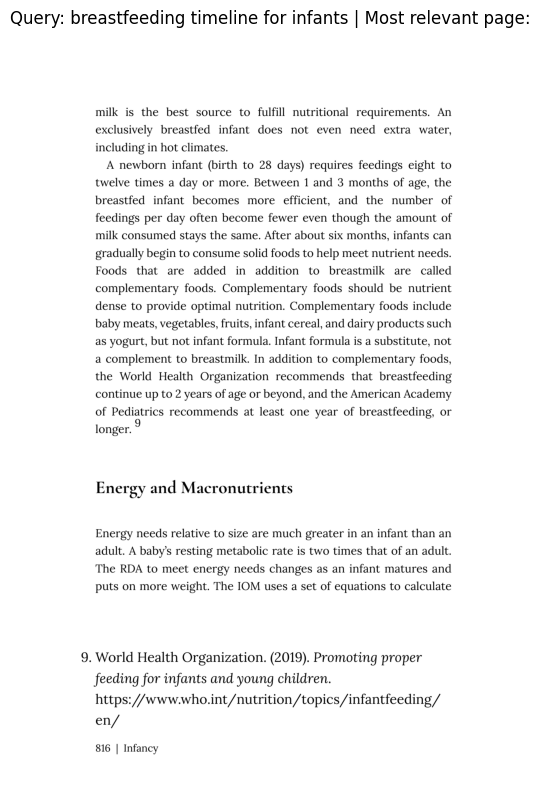

In [64]:
import fitz
import matplotlib.pyplot as plt

pdf_path = "/content/human-nutrition-text.pdf"

doc = fitz.open(pdf_path)

page = doc.load_page( 816+ 41)

img = page.get_pixmap(dpi = 300)

doc.close()

img_array = np.frombuffer(img.samples_mv,
                          dtype = np.uint8).reshape((img.h, img.w, img.n))

# img_array

plt.figure(figsize = (13, 10))
plt.imshow(img_array)
plt.title(f"Query: {query} | Most relevant page: ")

plt.axis('off')
plt.show()



In [65]:
embeddings.shape

torch.Size([1680, 768])

In [66]:
import torch

def dot_product(v1, v2):
  return torch.dot(v1, v2)

def cosine_similarity(v1, v2):
  dot_product = torch.dot(v1, v2)

  norm_v1 = torch.sqrt(torch.sum(v1**2))

  norm_v2 = torch.sqrt(torch.sum(v2**2))

  return dot_product / (norm_v1 * norm_v2)


v1 = torch.tensor([1, 2, 3], dtype = torch.float32)
v2 = torch.tensor([1, 2, 3], dtype = torch.float32)
v3 = torch.tensor([4, 5, 6], dtype = torch.float32)
v4 = torch.tensor([-1, -2, -3], dtype = torch.float32)

# trial code
print(f"dot product between v1 and v2 : {dot_product(v1, v2)}")
print(f"dot product between v1 and v3 : {dot_product(v1, v3)}")
print(f"dot product between v1 and v4 : {dot_product(v1, v4)}")
print("")

print(f"cosine_similarity between v1 and v2 : {cosine_similarity(v1, v2):.3f}")
print(f"cosine_similarity between v1 and v3 : {cosine_similarity(v1, v3):.3f}")
print(f"cosine_similarity between v1 and v4 : {cosine_similarity(v1, v4):.3f}")

dot product between v1 and v2 : 14.0
dot product between v1 and v3 : 32.0
dot product between v1 and v4 : -14.0

cosine_similarity between v1 and v2 : 1.000
cosine_similarity between v1 and v3 : 0.975
cosine_similarity between v1 and v4 : -1.000


In [67]:
query = 'foods high in fiber'
def retrieve_relevant_resources(query, embeddings, model: SentenceTransformer = embedding_model, n_returns = 5,print_time = True):

  query_embedding = model.encode(query, convert_to_tensor = True)

  start_time = timer()

  dot_scores = util.dot_score(query_embedding, embeddings)[0]
  end_time = timer()


  if print_time:
    print(f"Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds")

  s, i = torch.topk(dot_scores, n_returns)

  return s, i

def print_top_results_and_scores(query, embeddings, pages_and_chunks = pages_and_chunks, n_returns = 5):
  s, i = retrieve_relevant_resources(query=query, embeddings=embeddings, n_returns=n_returns)


  print("Results: ")

  for scores, idx in zip(s, i):
    print(f'Score: {scores:.4f}')
    print('Text:')
    print_wrapped(pages_and_chunks[idx]['sentence_chunk'])
    print(f'Page number: {pages_and_chunks[idx]["page_number"]}')
    print("_____________________________________________________")



In [68]:

retrieve_relevant_resources(query, embeddings)
print_top_results_and_scores(query = query, embeddings = embeddings)

Time taken to get scores on 1680 embeddings: 0.00007 seconds
Time taken to get scores on 1680 embeddings: 0.00009 seconds
Results: 
Score: 0.6964
Text:
• Change it up a bit and experience the taste and satisfaction of other whole grains such as barley,
quinoa, and bulgur. • Eat snacks high in fiber, such as almonds, pistachios, raisins, and air-popped
popcorn. Add an artichoke and green peas to your dinner plate more 276 | Carbohydrates and Personal
Diet Choices
Page number: 276
_____________________________________________________
Score: 0.6810
Text:
Dietary fiber is categorized as either water-soluble or insoluble. Some examples of soluble fibers
are inulin, pectin, and guar gum and they are found in peas, beans, oats, barley, and rye. Cellulose
and lignin are insoluble fibers and a few dietary sources of them are whole-grain foods, flax,
cauliflower, and avocados. Cellulose is the most abundant fiber in plants, making up the cell walls
and providing structure. Soluble fibers are mor

## getting an LLM for local generation
__

In [3]:
torch.tensor([1.]).dtype

torch.float32

In [4]:
import torch

gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory

gpu_memory_gb = round(gpu_memory_bytes / (2 ** 30))

print(f"Available GPU memory : {gpu_memory_gb} GB")

Available GPU memory : 15 GB


In [5]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False
    model_id = "google/gemma-7b-it"

print(f"use_quantization_config set to: {use_quantization_config}")
print(f"model_id set to: {model_id}")

GPU memory: 15 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2b-it


##Loading LLM model

In [7]:
from huggingface_hub import login
login()

https://huggingface.co/google/gemma-2b-it

In [9]:
!pip install bitsandbytes accelerate

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available

from transformers import BitsAndBytesConfig


quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                         bnb_4bit_compute_dtype=torch.float16)

if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"
print(f"Using attention implementation: {attn_implementation}")

Using attention implementation: sdpa


In [12]:
model_id

'google/gemma-2b-it'

In [13]:
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [14]:
llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                                 torch_dtype=torch.float16,
                                                 quantization_config=quantization_config if use_quantization_config else None,
                                                 low_cpu_mem_usage=False,
                                                 attn_implementation=attn_implementation)

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [15]:
llm_model

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaR

In [69]:
def get_model_num_param(model):
  return sum([param.numel() for param in model.parameters()])

get_model_num_param(llm_model)

2506172416

In [70]:
def get_model_mem_size(model):


    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    model_mem_bytes = mem_params + mem_buffers
    model_mem_mb = model_mem_bytes / (1024**2)
    model_mem_gb = model_mem_bytes / (1024**3)

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)

{'model_mem_bytes': 5012354048, 'model_mem_mb': 4780.15, 'model_mem_gb': 4.67}

##Generating text with LLM

In [77]:
input_text = "how long should infants be breastfeed for?"
print(f"Input text:\n{input_text}")


Input text:
how long should infants be breastfeed for?


Create Prompt Template for above text

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git accelerate

In [78]:

dialogue_template = [
    {"role": "user",
     "content": input_text}
]


prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False,
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")


Prompt (formatted):
<bos><start_of_turn>user
how long should infants be breastfeed for?<end_of_turn>
<start_of_turn>model



In [79]:
## Tokenize the input text
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")



Model input (tokenized):
{'input_ids': tensor([[     2,      2,    106,   1645,    108,   1139,   1497,   1412,  45770,
            614,  14665,  24824,    604, 235336,    107,    108,    106,   2516,
            108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}



In [80]:
outputs = llm_model.to('cuda').generate(**input_ids,
                             max_new_tokens=256)
print(f"Model output (tokens):\n{outputs[0]}\n")

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,   1139,   1497,   1412,  45770,
           614,  14665,  24824,    604, 235336,    107,    108,    106,   2516,
           108,    651,   3725,  13322,    576, 125142,    591,  79569, 235275,
         42767,  84810,    604,    696,   3476, 235248, 235318,   4063, 235269,
           675,   7822,  84810,    604,    685,   1497,    685,   2145,   5290,
           578,   5760,  12005, 235265,      1], device='cuda:0')



In [81]:
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<bos><bos><start_of_turn>user
how long should infants be breastfeed for?<end_of_turn>
<start_of_turn>model
The American Academy of Pediatrics (AAP) recommends breastfeeding for at least 6 months, with continued breastfeeding for as long as both mother and baby desire.<eos>



In [82]:

gpt4_questions = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management."
]

manual_questions = [
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

query_list = gpt4_questions + manual_questions

In [85]:
import random
query = random.choice(query_list)

print(f"Query: {query}")


scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

Query: How often should infants be breastfed?
Time taken to get scores on 1680 embeddings: 0.00008 seconds


(tensor([0.6205, 0.6067, 0.5696, 0.5624, 0.5307], device='cuda:0'),
 tensor([1151, 1160, 1144, 1138, 1155], device='cuda:0'))

Based on following contexts:
 - 40sjslajfjsd
 -lkjkljlfgj
 -jkjlkjds;f
 -tjrsljdf;sdfdkf
 -,smdnfdf

 Please answer the following prompt query

In [227]:
def prompt_formatter(query, context_items):


    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # prompt = context
    # base_prompt = """Based on the following context items, please answer the query.

    # Context items:
    # {context}

    # Query: {query}

    # Answer:
    # """

    base_prompt = """Based on the following context items, please answer the query.
    Give yourself room to think by extracting relevant passages from the context before answering the query.
    Don't return the thinking, only return the answer.
    Make sure your answers are as explanatory as possible.

    Use the following examples as reference for the ideal answer style.
    \nExample 1:
    Query: What are the fat-soluble vitamins?
    Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
    \nExample 2:
    Query: What are the causes of type 2 diabetes?
    Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
    \nExample 3:
    Query: What is the importance of hydration for physical performance?
    Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
    \nNow use the following context items to answer the user query:
    {context}

    \nRelevant passages: <extract relevant passages from the context here>

    User query: {query}
    Answer:
    # """

    base_prompt = base_prompt.format(context = context, query = query)
    # prompt = base_prompt.format(context = context, query = query)

    dialogue_temp = [
        {
            "role" : "user",
            "content": base_prompt
        }
    ]

    prompt = tokenizer.apply_chat_template(conversation = dialogue_temp,
                                           tokenize = False,
                                           add_generation_prompt = True)


    return prompt

# query = random.choice(query_list)
query = "Explain the concept of energy balance and its importance in weight management."
# query = "total how many months infants should be breastfed?"
print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query, embeddings)

context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query, context_items)
print(prompt)

Query: Explain the concept of energy balance and its importance in weight management.
Time taken to get scores on 1680 embeddings: 0.00009 seconds
<bos><start_of_turn>user
Based on the following context items, please answer the query.
    Give yourself room to think by extracting relevant passages from the context before answering the query.
    Don't return the thinking, only return the answer.
    Make sure your answers are as explanatory as possible.

    Use the following examples as reference for the ideal answer style.
    
Example 1:
    Query: What are the fat-soluble vitamins?
    Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cel

In [208]:
%%time

input_ids = tokenizer(prompt, return_tensors = 'pt').to("cuda")

outputs = llm_model.generate(**input_ids,
                              temperature = 0.7,
                              do_sample = True,
                             max_new_tokens = 256)

output_text = tokenizer.decode(outputs[0])

print(f"query:{query}")
print(f"RAG Answer:\n{output_text.replace(prompt, '')}")

query:total how many months infants should be breastfed?
RAG Answer:
<bos>According to the context items, infants should be breastfed up to 2 years of age or beyond.<eos>
CPU times: user 1.06 s, sys: 4.87 ms, total: 1.07 s
Wall time: 1.07 s


In [229]:
%%time

input_ids = tokenizer(prompt, return_tensors = 'pt').to("cuda")

outputs = llm_model.generate(**input_ids,
                              temperature = 0.7,
                              do_sample = True,
                             max_new_tokens = 256)

output_text = tokenizer.decode(outputs[0])

print(f"query:{query}")
print(f"RAG Answer:\n{output_text.replace(prompt, '')}")

query:Explain the concept of energy balance and its importance in weight management.
RAG Answer:
<bos>Sure, here's the answer to the user's query:

**Concept of Energy Balance:**
Energy balance refers to the equilibrium between energy intake and expenditure. Energy intake refers to the amount of energy you take in through food and beverages, while energy expenditure refers to the amount of energy your body uses for various functions. When energy intake equals energy expenditure, your body is in a state of energy balance.

However, when energy intake exceeds energy expenditure, your body will store the excess energy as fat for later use. Conversely, when energy expenditure exceeds energy intake, your body will use its stores of fat and/or muscle tissue to provide energy. Maintaining energy balance is crucial for overall health, including weight management.<eos>
CPU times: user 4.8 s, sys: 4.43 ms, total: 4.8 s
Wall time: 4.82 s


In [11]:
# model_id = "google/gemma-2b-it"

# from transformers import AutoTokenizer, AutoModelForCausalLM
# from transformers.utils import is_flash_attn_2_available

# from transformers import BitsAndBytesConfig


# bnb_config = BitsAndBytesConfig(
#     load_in_4bit = True,
#     bnb_4bit_use_double_quant = True,
#     bnb_4bit_quant_type = 'nf4',
#     bnb_4bit_compute_dtype = torch.bfloat16
# )